In [ ]:
# default_exp data.validation

# Spliting data

> Functions required to perform cross-validation and transform unique time series sequence into multiple samples ready to be used by a time series model.

In [ ]:
#export
from imblearn.over_sampling import RandomOverSampler
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from tsai.imports import *
from tsai.utils import *

In [ ]:
#export
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(list(torch.randperm(len(o)).numpy()))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
#export
def check_overlap(a, b, c=None):
    a = toarray(a)
    b = toarray(b)
    overlap_ab = np.isin(a, b)
    if c is None:
        if isinstance(overlap_ab[0], (list, L, np.ndarray, torch.Tensor)):  overlap_ab = overlap_ab[0] 
        if not any(overlap_ab): return False
        else: return a[overlap_ab].tolist()
    else:
        c = toarray(c)
        overlap_ac = np.isin(a, c)
        if isinstance(overlap_ac[0], (list, L, np.ndarray, torch.Tensor)):  overlap_ac = overlap_ac[0] 
        overlap_bc = np.isin(b, c)
        if isinstance(overlap_bc[0], (list, L, np.ndarray, torch.Tensor)):  overlap_bc = overlap_bc[0] 
        if not any(overlap_ab) and not any(overlap_ac) and not any(overlap_bc): return False
        else: return a[overlap_ab].tolist(), a[overlap_ac].tolist(), b[overlap_bc].tolist()

def check_splits_overlap(splits):
    return [check_overlap(*_splits) for _splits in splits] if is_listy(splits[0][0]) else check_overlap(*splits)

def leakage_finder(*splits, verbose=True):
    '''You can pass splits as a tuple, or train, valid, ...'''
    splits = L(*splits)
    overlaps = 0
    for i in range(len(splits)):
        for j in range(i + 1, len(splits)):
            overlap = check_overlap(splits[i], splits[j])
            if overlap: 
                pv(f'overlap between splits [{i}, {j}] {overlap}', verbose)
                overlaps += 1
    assert overlaps == 0, 'Please, review your splits!'

def balance_idx(o, shuffle=False, random_state=None, verbose=False):
    if isinstance(o, list): o = L(o)
    idx_ = np.arange(len(o)).reshape(-1, 1)
    ros = RandomOverSampler(random_state=random_state)
    resampled_idxs, _ = ros.fit_resample(idx_, np.asarray(o))
    new_idx = L(resampled_idxs.reshape(-1,).tolist())
    if shuffle: new_idx = random_shuffle(new_idx)
    return new_idx

In [ ]:
a = np.arange(10)
b = np.arange(10, 20)
test_eq(check_overlap(a, b), False)
a = np.arange(10)
b = np.arange(9, 20)
test_eq(check_overlap(a, b), [9])
a = np.arange(10)
b = np.arange(10, 20)
c = np.arange(20, 30)
test_eq(check_overlap(a, b, c), False)
a = np.arange(10)
b = np.arange(10, 20)
c = np.arange(10, 30)
test_eq(check_overlap(a, b, c), ([], [], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

In [ ]:
o = np.concatenate([np.ones(10), np.ones(20)*2, np.ones(30)*3])
idxs = balance_idx(o)
np.unique(o[idxs], return_counts=True)

(array([1., 2., 3.]), array([30, 30, 30]))

In [ ]:
l = L(list(concat(np.zeros(5), np.ones(10)).astype(int)))
balanced_idx = balance_idx(l)
test_eq(np.mean(l[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

l = list(concat(np.zeros(5), np.ones(10)).astype(int))
balanced_idx = balance_idx(l)
test_eq(np.mean(L(l)[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

a = concat(np.zeros(5), np.ones(10)).astype(int)
balanced_idx = balance_idx(a)
test_eq(np.mean(a[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

t = concat(torch.zeros(5), torch.ones(10))
balanced_idx = balance_idx(t, shuffle=True)
test_eq(t[balanced_idx].mean(), 0.5)
test_eq(isinstance(balanced_idx, L), True)

In [ ]:
a, b = np.arange(100_000), np.arange(100_000, 200_000)

In [ ]:
soft_labels = True
filter_pseudolabels = .5
balanced_pseudolabels = True

pseudolabels = torch.rand(1000, 3)
pseudolabels = torch.softmax(pseudolabels, -1) if soft_labels else torch.argmax(pseudolabels, -1)
hpl = torch.argmax(pseudolabels, -1) if soft_labels else pseudolabels

if filter_pseudolabels and pseudolabels.ndim > 1: 
    error = 1 - pseudolabels.max(-1).values
    filt_pl_idx = np.arange(len(error))[error < filter_pseudolabels]
    filt_pl = pseudolabels[error < filter_pseudolabels]
    assert len(filt_pl) > 0, 'no filtered pseudolabels'
    filt_hpl = torch.argmax(filt_pl, -1)
else: 
    filt_pl_idx = np.arange(len(pseudolabels))
    filt_pl = filt_hpl = pseudolabels

In [ ]:
pl_split = filt_pl_idx[balance_idx(filt_hpl)] if balanced_pseudolabels else filt_pl_idx
test_eq(hpl[pl_split].float().mean(), np.mean(np.unique(hpl)))

In [ ]:
#export
def TrainValidTestSplitter(n_splits:int=1, valid_size:Union[float, int]=0.2, test_size:Union[float, int]=0., train_only:bool=False,
                           stratify:bool=True, balance:bool=False, shuffle:bool=True, random_state:Union[None, int]=None, verbose:bool=False, **kwargs):
    "Split `items` into random train, valid (and test optional) subsets."
    
    if not shuffle and stratify and not train_only: 
        pv('stratify set to False because shuffle=False. If you want to stratify set shuffle=True', verbose)
        stratify = False
        
    def _inner(o, **kwargs):
        if stratify:
            _, unique_counts = np.unique(o, return_counts=True)
            if np.min(unique_counts) >= 2 and np.min(unique_counts) >= n_splits: stratify_ = stratify  
            elif np.min(unique_counts) < n_splits: 
                stratify_ = False
                pv(f'stratify set to False as n_splits={n_splits} cannot be greater than the min number of members in each class ({np.min(unique_counts)}).', 
                   verbose)
            else:
                stratify_ = False
                pv('stratify set to False as the least populated class in o has only 1 member, which is too few.', verbose)
        else: stratify_ = False
        vs = 0 if train_only else 1. / n_splits if n_splits > 1 else int(valid_size * len(o)) if isinstance(valid_size, float) else valid_size
        if test_size: 
            ts = int(test_size * len(o)) if isinstance(test_size, float) else test_size
            train_valid, test = train_test_split(range(len(o)), test_size=ts, stratify=o if stratify_ else None, shuffle=shuffle, 
                                                 random_state=random_state, **kwargs)
            test = toL(test)
            if shuffle: test = random_shuffle(test, random_state)
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o[train_valid])
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                test_ = L(L([test]) * n_splits) if n_splits > 1 else test
                if n_splits > 1: 
                    return [split for split in itemify(train_, valid_, test_)]
                else: 
                    return train_, valid_, test_
            elif n_splits > 1: 
                if stratify_: 
                    splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)), o[train_valid])
                else:
                    splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    train_.append(L(L(train_valid)[train]))
                    valid_.append(L(L(train_valid)[valid]))
                test_ = L(L([test]) * n_splits)
                return [split for split in itemify(train_, valid_, test_)]
            else:
                train, valid = train_test_split(range(len(train_valid)), test_size=vs, random_state=random_state, 
                                                stratify=o[train_valid] if stratify_ else None, shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: 
                    train = random_shuffle(train, random_state)
                    valid = random_shuffle(valid, random_state)
                return (L(L(train_valid)[train]), L(L(train_valid)[valid]),  test)
        else: 
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o)
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                if n_splits > 1: 
                    return [split for split in itemify(train_, valid_)]
                else: 
                    return (train_, valid_)
            elif n_splits > 1: 
                if stratify_: splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)), o)
                else: splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    if not isinstance(train, (list, L)):  train = train.tolist()
                    if not isinstance(valid, (list, L)):  valid = valid.tolist()
                    train_.append(L(train))
                    valid_.append(L(L(valid)))
                return [split for split in itemify(train_, valid_)]
            else:
                train, valid = train_test_split(range(len(o)), test_size=vs, random_state=random_state, stratify=o if stratify_ else None, 
                                                shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state)]
                return train, valid
    return _inner

In [ ]:
#export
def plot_splits(splits):
    _max = 0
    _splits = 0
    for i, split in enumerate(splits):
        if is_listy(split[0]):
            for j, s in enumerate(split):
                _max = max(_max, array(s).max())
                _splits += 1
        else: 
            _max = max(_max, array(split).max())
            _splits += 1
    _splits = [splits] if not is_listy(split[0]) else splits
    v = np.zeros((len(_splits), _max + 1))
    for i, split in enumerate(_splits):
        if is_listy(split[0]):
            for j, s in enumerate(split): 
                v[i, s] = 1 + j
        else: v[i, split] = 1 + i
    vals = np.unique(v)
    plt.figure(figsize=(16, len(_splits)/2))
    if len(vals) == 1:
        v = np.ones((len(_splits), _max + 1))
        plt.pcolormesh(v, color='blue')
        legend_elements = [Patch(facecolor='blue', label='Train')]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    else: 
        colors = L(['gainsboro', 'blue', 'limegreen', 'red'])[vals]
        cmap = LinearSegmentedColormap.from_list('', colors)
        plt.pcolormesh(v, cmap=cmap)
        legend_elements = L([
            Patch(facecolor='gainsboro', label='None'),
            Patch(facecolor='blue', label='Train'),
            Patch(facecolor='limegreen', label='Valid'),
            Patch(facecolor='red', label='Test')])[vals]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Split distribution')
    plt.yticks(ticks=np.arange(.5, len(_splits)+.5, 1.0), labels=np.arange(1, len(_splits)+1, 1.0).astype(int))
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
#export
def get_splits(o, n_splits:int=1, valid_size:float=0.2, test_size:float=0., train_only:bool=False, train_size:Union[None, float, int]=None, balance:bool=False,
               shuffle:bool=True, stratify:bool=True, check_splits:bool=True, random_state:Union[None, int]=None, show_plot:bool=True, verbose:bool=False):
    '''Arguments: 
        o            : object to which splits will be applied, usually target.
        n_splits     : number of folds. Must be an int >= 1.
        valid_size   : size of validation set. Only used if n_splits = 1. If n_splits > 1 valid_size = (1. - test_size) / n_splits. 
        test_size    : size of test set. Default = 0.
        train_only   : if True valid set == train set. This may be useful for debugging purposes.
        train_size   : size of the train set used. Default = None (the remainder after assigning both valid and test). 
                        Useful for to get learning curves with different train sizes or get a small batch to debug a neural net.
        balance      : whether to balance data so that train always contain the same number of items per class.
        shuffle      : whether to shuffle data before splitting into batches. Note that the samples within each split will be shuffle.
        stratify     : whether to create folds preserving the percentage of samples for each class.
        check_splits : whether to perform leakage and completion checks.
        random_state : when shuffle is True, random_state affects the ordering of the indices. Pass an int for reproducible output.
        show_plot    : plot the split distribution
    '''
    if n_splits == 1 and valid_size == 0. and  test_size == 0.: train_only = True
    if balance: stratify = True
    splits = TrainValidTestSplitter(n_splits, valid_size=valid_size, test_size=test_size, train_only=train_only, stratify=stratify, 
                                      balance=balance, shuffle=shuffle, random_state=random_state, verbose=verbose)(o)
    if check_splits:
        if train_only or (n_splits == 1 and valid_size == 0): print('valid == train')
        elif n_splits > 1: 
            for i in range(n_splits): 
                leakage_finder([*splits[i]], verbose=True)
                cum_len = 0
                for split in splits[i]: cum_len += len(split)
                if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
        else: 
            leakage_finder([splits], verbose=True)
            cum_len = 0
            if not isinstance(splits[0], Integral):
                for split in splits: cum_len += len(split)
            else: cum_len += len(splits)
            if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
    if train_size is not None and train_size != 1: # train_size=1 legacy
        if n_splits > 1:
            splits = list(splits)
            for i in range(n_splits): 
                splits[i] = list(splits[i])
                if isinstance(train_size, Integral):
                    n_train_samples = train_size  
                elif train_size > 0 and train_size < 1: 
                    n_train_samples = int(len(splits[i][0]) * train_size)
                splits[i][0] = L(np.random.choice(splits[i][0], n_train_samples, False).tolist())
                if train_only:
                    if valid_size != 0: splits[i][1] = splits[i][0]
                    if test_size != 0: splits[i][2] = splits[i][0]
                splits[i] = tuple(splits[i])
            splits = tuple(splits)
        else: 
            splits = list(splits)
            if isinstance(train_size, Integral):
                n_train_samples = train_size  
            elif train_size > 0 and train_size < 1: 
                n_train_samples = int(len(splits[0]) * train_size)
            splits[0] = L(np.random.choice(splits[0], n_train_samples, False).tolist())
            if train_only:
                if valid_size != 0: splits[1] = splits[0]
                if test_size != 0: splits[2] = splits[0]
            splits = tuple(splits)
    if show_plot: plot_splits(splits)
    return splits

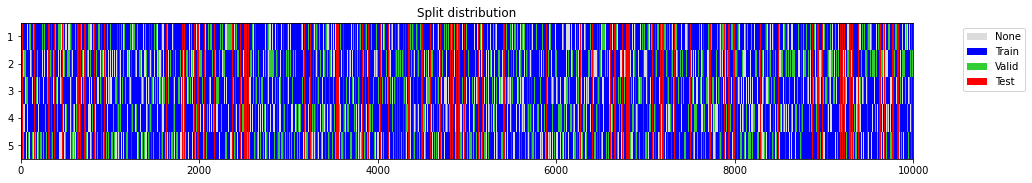

(((#5000) [7956,8176,3296,9930,3814,9769,4398,8390,9025,1625...],
  (#1600) [965,3817,83,1608,1703,7870,8817,1585,4249,471...],
  (#2000) [9529,4348,9487,4289,3765,5782,4951,3154,3622,6636...]),
 ((#5000) [504,1825,8589,3194,86,67,5028,6232,7656,9285...],
  (#1600) [7777,8617,1284,2338,130,8588,237,9298,6398,5762...],
  (#2000) [9529,4348,9487,4289,3765,5782,4951,3154,3622,6636...]),
 ((#5000) [8544,5806,5778,5556,2869,5200,917,8050,8526,3752...],
  (#1600) [9983,1553,5322,4933,9220,7820,5304,9773,6448,4023...],
  (#2000) [9529,4348,9487,4289,3765,5782,4951,3154,3622,6636...]),
 ((#5000) [5752,8016,8054,3918,9029,7212,1758,9723,7854,301...],
  (#1600) [3310,4370,2110,5556,9147,1142,2688,7495,2254,6865...],
  (#2000) [9529,4348,9487,4289,3765,5782,4951,3154,3622,6636...]),
 ((#5000) [511,6674,3478,478,5684,9496,3423,7453,6055,5061...],
  (#1600) [3467,9402,5655,1978,5406,6478,2602,125,128,9185...],
  (#2000) [9529,4348,9487,4289,3765,5782,4951,3154,3622,6636...]))

In [ ]:
n_splits                = 5
valid_size              = 0.2
test_size               = 0.2
train_only              = False  # set to True for debugging (valid = train)
train_size              = 5000
stratify                = True
balance                 = False
shuffle                 = True
predefined_splits       = None
show_plot               = True 


check_splits = True
random_state = 23

y = np.random.randint(0, 3, 10000) + 100

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
splits

valid == train


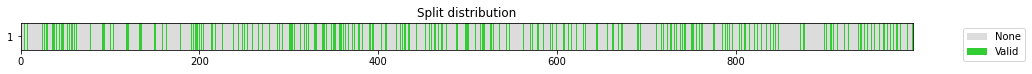

((#256) [693,727,696,906,536,856,91,253,585,909...],
 (#256) [693,727,696,906,536,856,91,253,585,909...])

In [ ]:
train_size=256
y = np.random.randint(0, 3, 1000) + 100
splits = get_splits(y, train_size=train_size, train_only=True)
test_eq(splits[0], splits[1])
test_eq(len(splits[0]), train_size)
splits

In [ ]:
#export
def TSSplitter(valid_size:Union[int, float]=0.2, test_size:Union[int, float]=0., show_plot:bool=True):
    "Create function that splits `items` between train/val with `valid_size` without shuffling data."
    def _inner(o):
        valid_cut = valid_size if isinstance(valid_size, Integral) else int(round(valid_size * len(o)))
        if test_size: 
            test_cut = test_size if isinstance(test_size, Integral) else int(round(test_size * len(o)))
        idx = np.arange(len(o))
        if test_size: 
            splits = L(idx[:-valid_cut - test_cut].tolist()), L(idx[-valid_cut - test_cut: - test_cut].tolist()), L(idx[-test_cut:].tolist())
        else: 
            splits = L(idx[:-valid_cut].tolist()), L(idx[-valid_cut:].tolist())
        if show_plot: 
            if len(o) > 1_000_000:
                warnings.warn('the splits are too large to be plotted')
            else: 
                plot_splits(splits)
        return splits
    return _inner

TimeSplitter = TSSplitter

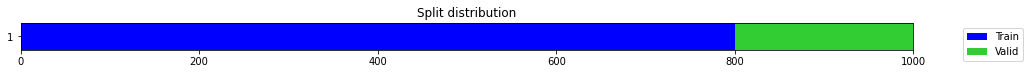

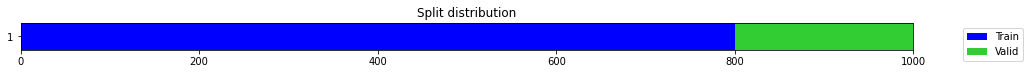

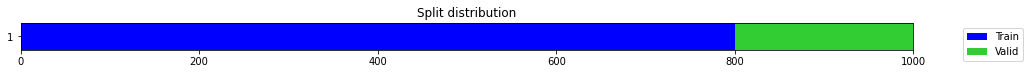

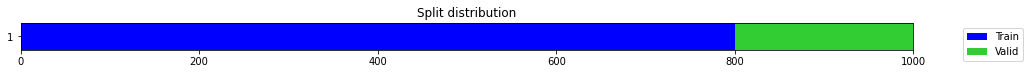

((#800) [0,1,2,3,4,5,6,7,8,9...],
 (#200) [800,801,802,803,804,805,806,807,808,809...])

In [ ]:
y = np.arange(1000) + 100
test_eq(TimeSplitter(valid_size=0.2)(y)[1], L(np.arange(800, 1000).tolist()))
test_eq(TimeSplitter(valid_size=0.2)(y)[0], TimeSplitter(valid_size=200)(y)[0])
TimeSplitter(valid_size=0.2, show_plot=True)(y)

stratify set to False as n_splits=5 cannot be greater than the min number of members in each class (1).


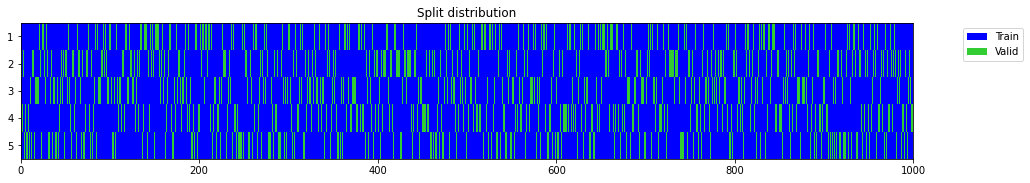

(601.11, (#800) [314,194,782,789,502,917,137,415,904,181...])

In [ ]:
n_splits                = 5
valid_size              = 0.2  
test_size               = 0
train_only              = False  # set to True for debugging (valid = train)
train_size              = None
stratify                = True
balance                 = True
shuffle                 = True
predefined_splits       = None
show_plot               = True 


check_splits = True
random_state = 23

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
split = splits[0] if n_splits == 1 else splits[0][0]
y[split].mean(), split

In [ ]:
list([splits[0], splits[1], splits[2], splits[3], splits[4]])

[((#800) [314,194,782,789,502,917,137,415,904,181...],
  (#200) [362,151,934,378,95,597,500,117,980,844...]),
 ((#800) [312,198,777,788,515,910,145,413,898,186...],
  (#200) [352,133,955,396,64,596,442,79,991,882...]),
 ((#800) [311,197,783,791,507,922,145,416,908,184...],
  (#200) [338,125,912,361,54,594,486,88,994,859...]),
 ((#800) [296,181,782,789,493,917,130,401,905,165...],
  (#200) [405,199,953,444,113,610,515,137,997,881...]),
 ((#800) [320,190,782,788,506,906,141,412,893,178...],
  (#200) [336,149,942,358,49,582,472,70,990,907...])]

stratify set to False as n_splits=5 cannot be greater than the min number of members in each class (1).
valid == train


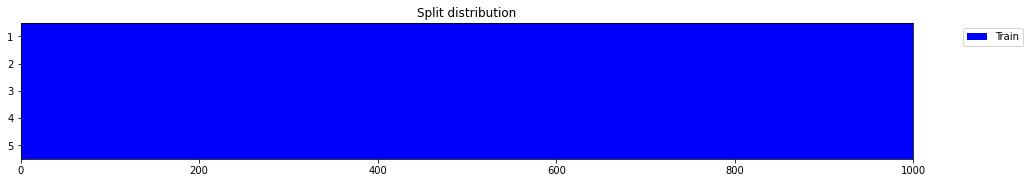

In [ ]:
n_splits = 5
valid_size = 0.
test_size = 0.
shuffle = True
stratify = True
train_only = True
train_size = None
check_splits = True
random_state = 1
show_plot = True 

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
for split in splits: 
    test_eq(len(split[0]), len(y))
    test_eq(np.sort(split[0]), np.arange(len(y)))

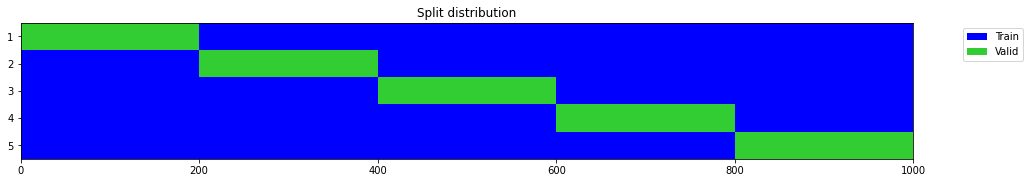

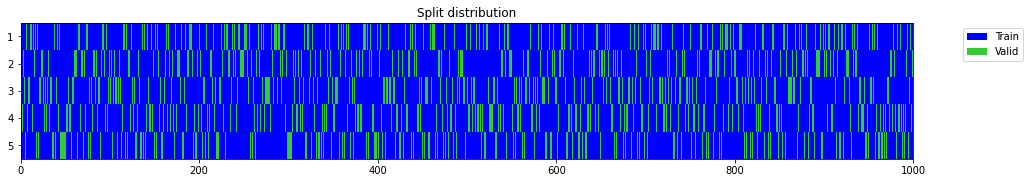

In [ ]:
n_splits = 5
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, shuffle=False, check_splits=True)
test_eq(np.concatenate((L(zip(*splits))[1])), np.arange(len(y)))

splits = get_splits(y, n_splits=n_splits, shuffle=True, check_splits=True)
test_eq(np.sort(np.concatenate((L(zip(*splits))[1]))), np.arange(len(y)))

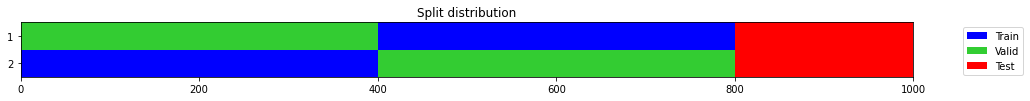

In [ ]:
n_splits = 2
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, test_size=0.2, shuffle=False)
for i in range(n_splits): leakage_finder(*splits[i])
test_eq(len(splits), n_splits)
test_eq(len(splits[0]), 3)
s = []
[s.extend(split) for split in splits[0]]
test_eq(np.sort(s), np.arange(len(y)))
s = []
[s.extend(split) for split in splits[1]]
test_eq(np.sort(s), np.arange(len(y)))

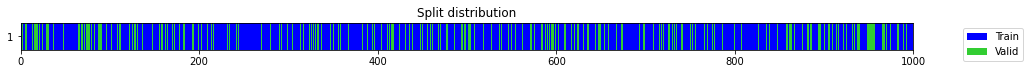

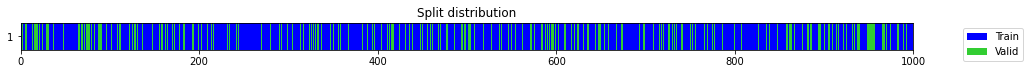

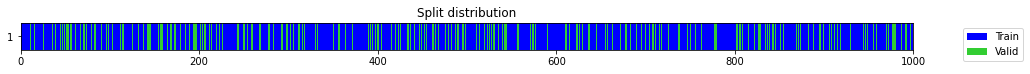

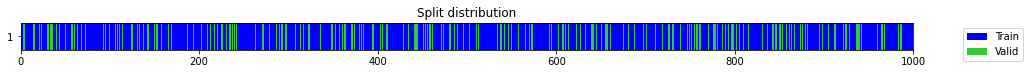

In [ ]:
y = np.random.randint(0, 2, 1000)
splits1 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits2 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits3 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
splits4 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
test_eq(splits1[0], splits2[0])
test_ne(splits3[0], splits4[0])

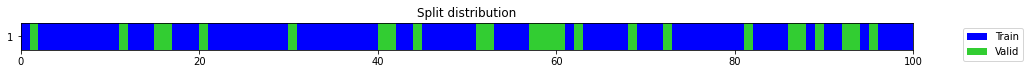

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
test_eq(len(splits), 2)

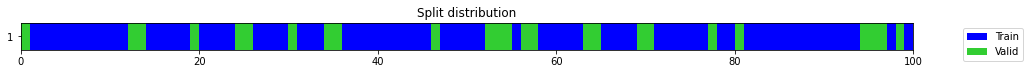

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True)
test_eq(len(splits), 2)

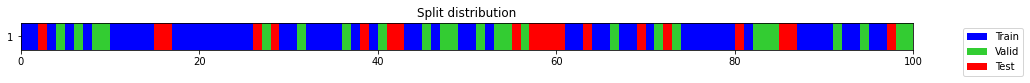

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=20, random_state=23, stratify=True)
test_eq(len(splits), 3)
leakage_finder(*splits)

In [ ]:
splits = TrainValidTestSplitter(valid_size=.25, test_size=20, random_state=23, stratify=True)(np.random.randint(0, 2, 100))
test_eq(len(splits[1]), 25)
test_eq(len(splits[2]), 20)

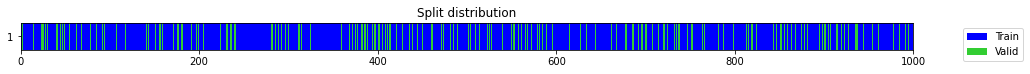

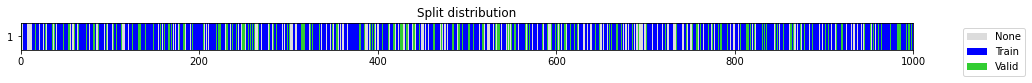

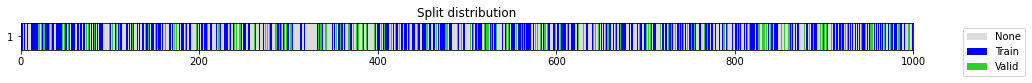

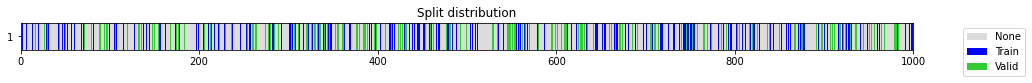

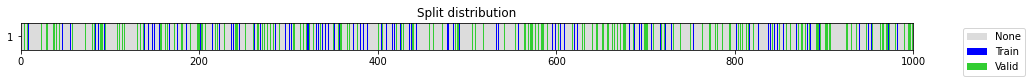

In [ ]:
o = np.random.randint(0, 2, 1000)
for p in [1, .75, .5, .25, .125]:
    splits = get_splits(o, train_size=p)
    test_eq(len(splits[0]), len(o) * .8 * p)

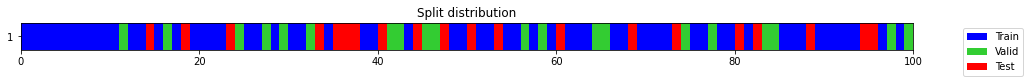

((#60) [22,61,19,12,49,52,9,92,51,0...],
 (#20) [24,41,27,84,65,77,16,11,58,99...],
 (#20) [44,37,36,80,35,50,94,18,33,60...])

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, valid_size=.2, test_size=.2)
test_eq(np.mean(y[splits[0]])==np.mean(y[splits[1]])==np.mean(y[splits[2]]), True)
splits

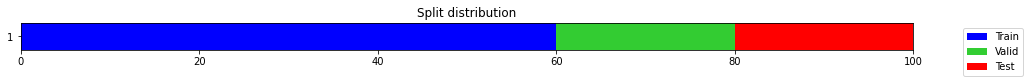

((#60) [0,1,2,3,4,5,6,7,8,9...],
 (#20) [60,61,62,63,64,65,66,67,68,69...],
 (#20) [80,81,82,83,84,85,86,87,88,89...])

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, n_splits=1, valid_size=.2, test_size=.2, shuffle=False)
# test_eq(splits[0] + splits[1] + splits[2], np.arange(100))
splits

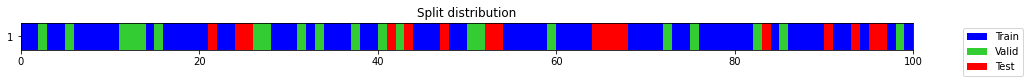

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17)
test_eq(len(splits[1]), 21)
test_eq(len(splits[2]), 17)

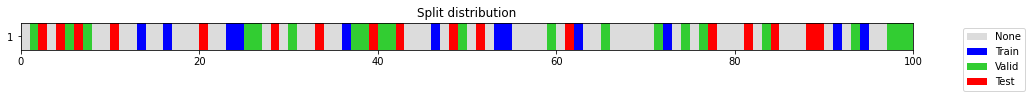

((#12) [54,24,62,23,53,72,46,36,94,16...],
 (#21) [74,83,59,93,49,76,71,26,65,41...],
 (#17) [48,89,84,81,51,42,20,28,33,39...])

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17, train_size=.2)
splits

In [ ]:
#export
def get_predefined_splits(*xs):
    '''xs is a list with X_train, X_valid, ...'''
    splits_ = []
    start = 0
    for x in xs: 
        splits_.append(L(list(np.arange(start, start + len(x)))))
        start += len(x)
    return tuple(splits_)

def combine_split_data(xs, ys=None):
    '''xs is a list with X_train, X_valid, .... ys is None or a list with y_train, y_valid, .... '''
    xs = [to3d(x) for x in xs]
    splits = get_predefined_splits(*xs)
    if ys is None: return concat(*xs), None, splits
    else: return concat(*xs), concat(*ys), splits

In [ ]:
#export
def get_splits_len(splits):
    _len = []
    for split in splits: 
        if isinstance(split[0], (list, L, tuple)):  _len.append([len(s) for s in split])
        else: _len.append(len(split))
    return _len

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,3,4), np.random.randint(0,2,3), np.random.rand(2,3,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train, X[splits[0]])
test_eq(X_valid, X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,4), np.random.randint(0,2,3), np.random.rand(2,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train[:, None], X[splits[0]])
test_eq(X_valid[:, None], X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

In [ ]:
#export
def save_splits(*splits, file_path, verbose=True):
    if file_path.split('.')[-1] != 'npy': 
        file_path = '.'.join([file_path, 'npy'])
    file_path = Path(file_path)
    create_dir(file_path.parent, verbose)
    keys = [f'split_{i}' for i in np.arange(len(splits))]
    split_dict = dict(zip(keys, splits))
    np.save(file_path, split_dict) 
    pv(f'{len(splits)} {("splits" if len(splits) > 1 else "split")} saved as {file_path}', verbose)


def load_splits(file_path):
    split_dict = np.load(file_path,allow_pickle=True).item()
    return tuple(L(v.tolist()) for k,v in split_dict.items())

In [ ]:
split = np.arange(100)
save_splits(split, file_path='data/test')
split2 = load_splits('data/test.npy')
test_eq(split, split2)

data directory already exists.
1 split saved as data/test.npy


In [ ]:
splits = (np.arange(100), np.arange(100, 200), np.arange(200, 300), np.arange(300, 400))
save_splits(*splits, file_path='data/test')
splits2 = load_splits('data/test.npy')
test_eq(split, split2)

data directory already exists.
4 splits saved as data/test.npy


In [ ]:
#hide
from tsai.imports import *
from tsai.export import *
nb_name = get_nb_name()
nb_name = "010_data.validation.ipynb"
create_scripts(nb_name);

<IPython.core.display.Javascript object>

010_data.validation.ipynb saved at 2022-04-08 20:09:42.
Converted 010_data.validation.ipynb.


Correct conversion! 😃
Total time elapsed 0.126 s
Friday 08/04/22 20:09:46 CEST
